# Test of Reservoir Computer prediction of Lorenz '63 System

First, import necessary modules

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

## Define necessary  functions

In [2]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    # Evaluates derivative of Lorenz '63 system with a time-dependent
    # rho value. For constant rho, input the r_t_const function.
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    # Fourth order Runge-Kutta integrator
    
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    # Obtains time series of Lorenz '63 states after some initial transient time
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    # Function for oscillating rho value (not used here)
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    # Equation for advancing reservoir state. Here, we do not use a bias factor.
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    # Obtains a prediction of length predict_length given the trained reservoir parameters
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

## Next, define reservoir hyperparameters and the length of and number of predictions to be made. Finally,  we obtain a training and testing data sequence from the Lorenz '63 system.

In [3]:
input_weight = 1e-2 #Input weight for reservoir
spectral_radius = 0.9 #Spectral radius, maximum magnitude eigenvalue of reservoir adjacency matrix 
regularization = 1e-5 #Tikhonov regularization term
average_degree = 3 #Average in-degree for each reservoir node
leakage = 0 #Leakage parameter, unused
# forget = 1
# inv_forget = 1/forget
data_seed = 30  #Seed for initializing data
timestep = 1

step = 0.05 #Time step size for Lorenz system
transient_length = int(50/step) #Length of initial transient input to reservoir before training begins
data_length = int(3000/step) #Length of full data set
train_length = int(100/step) #Length of training data
predict_length = int(20/step)  #Length of each prediction
predict_gap_length = int(5/step) #Length of time between subsequent predictions
num_predictions = 100  #Total number of predictions made

approx_num_nodes = 300 #Approximate Number of nodes in the reservoir (rounded such that each input connects to the same number of nodes)
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05) #Obtain Lorenz Data

## Randomly generate reservoit adjacency and input matrices and initialize the reservoir node states.

In [4]:
input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size); #Calculate number of nodes

# Create the adjacency matrix and set the spectral radius
A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

# Set the adjacency matrix such that all inputs go to the same number of nodes
q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;
    
#Initialize reservoir state vector x and states array
x = np.zeros(num_nodes)
states = np.zeros((num_nodes, train_length))

## After an initial transient, record reservoir states and use them to calculate the output matrix.

In [5]:
# Advance reservoir state
for t in range(transient_length):
    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
    
#Begin recording states for training
states[:,0] = x;

for t in range(train_length-1):
    states[:,t+1] = advanceReservoir(win,A_mat,states[:,t],train_input_sequence[:,t+transient_length],leakage)
    
x = states[:,-1]

# We augment the reservoir states by squaring some of them to break the odd
# symmetry of the tanh function. We find experimentally that this improves
# performance for some systems.
aug_states = np.copy(states)
aug_states[::2,:] = np.power(states[::2,:],2)
idenmat = regularization*sparse.identity(num_nodes)
data_trstates = np.matmul(train_input_sequence[:,transient_length:transient_length+train_length],np.transpose(aug_states))
states_trstates = np.matmul(aug_states,np.transpose(aug_states))
states_trstates_inv = pinv(states_trstates + idenmat)
wout = np.matmul(data_trstates,states_trstates_inv)

## We evaluate the reservoir's performance over a set of prediction periods beginning right after training ends (this is not necessary, but is easiest). We then display the valid prediction times.

In [6]:
# Initialize data matrices
error_cutoff = 1;
predictions = np.zeros((input_size,predict_length,num_predictions))
errors = np.zeros((predict_length,num_predictions))
valid_times = np.zeros(num_predictions)


for pred in range(num_predictions):
    # Obtain the prediction
    predictions[:,:,pred] = getPrediction(win,A_mat,wout,x,predict_length,leakage)
    start_pred_idx = transient_length + train_length + pred*predict_gap_length - 1
    
    # Compare prediction to true system and calculate valid prediction time given the normalized RMS error cutoff
    truth = train_input_sequence[:,start_pred_idx:start_pred_idx + predict_length]
    errors[:,pred] = np.linalg.norm(predictions[:,:,pred] - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    for i in range(predict_length):
        if errors[i,pred] > error_cutoff:
            break
        else:
            valid_times[pred] += 1
    
    # Advance the reservoir node state to the next prediction
    for i in range(predict_gap_length):
        x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
    
    
print(valid_times*step)

[ 5.65  7.25  7.    6.55  6.65  4.85  7.8   9.6   5.5   5.2   6.2   5.
  6.8   7.05 10.45  6.2   7.9   7.4   6.95  6.7   6.85  7.35  7.8   5.9
  7.    5.7   6.95  9.55  6.9   6.45  6.85  3.65  8.95  4.25  6.9   7.35
  6.    5.6   6.5   6.8   6.45  5.4   5.7   5.75  7.5   6.55  6.7   7.
  5.95  3.65  4.95  7.35  6.3   7.15  6.8   5.75  7.5   6.15  9.75 10.1
  5.2   8.8   6.25  5.8   6.85  6.65  7.45  7.65  5.9   7.05 10.2   9.9
  5.65  7.7   6.9   8.75  6.55  6.85  9.25  7.3   6.35  4.55  7.75  5.65
  5.4   7.3   6.15 11.65  3.2   6.25  5.95  6.15  4.4   8.95  5.7   8.05
  6.9   5.7   6.85  4.3 ]


## Plot an example prediction

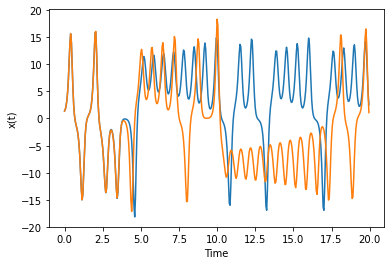

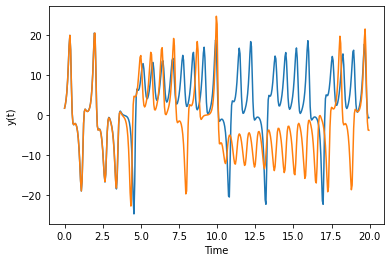

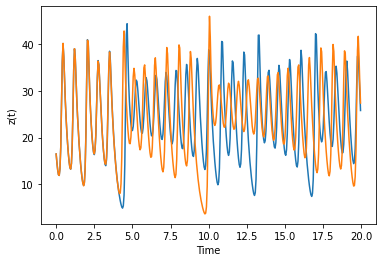

In [10]:
times = np.arange(0,step*predict_length,step)
plt.plot(times, truth[0,:],label = 'Truth')
plt.plot(times, predictions[0,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

plt.plot(times, truth[1,:],label = 'Truth')
plt.plot(times, predictions[1,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.show()

plt.plot(times, truth[2,:],label = 'Truth')
plt.plot(times, predictions[2,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('z(t)')
plt.show()